In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import urllib
import sys
import os
import zipfile
import tarfile
import json 
import hashlib
import re
import itertools

In [2]:

glove_zip_file = "glove.6B.zip"
glove_vectors_file = "glove.6B.50d.txt"

# 15 MB
data_set_zip = "tasks_1-20_v1-2.tar.gz"

#Select "task 5"
train_set_file = "qa5_three-arg-relations_train.txt"
test_set_file = "qa5_three-arg-relations_test.txt"

train_set_post_file = "tasks_1-20_v1-2/en/"+train_set_file
test_set_post_file = "tasks_1-20_v1-2/en/"+test_set_file

In [3]:
# Deserialize GloVe vectors
glove_wordmap = {}
with open(glove_vectors_file, "r", encoding="utf8") as glove:
    for line in glove:
        name, vector = tuple(line.split(" ", 1))
        glove_wordmap[name] = np.fromstring(vector, sep=" ")

In [4]:
wvecs = []
for item in glove_wordmap.items():
    wvecs.append(item[1])
s = np.vstack(wvecs)

# Gather the distribution hyperparameters
v = np.var(s,0) 
m = np.mean(s,0) 
RS = np.random.RandomState()

def fill_unk(unk):
    global glove_wordmap
    glove_wordmap[unk] = RS.multivariate_normal(m,np.diag(v))
    return glove_wordmap[unk]

In [5]:
def sentence2sequence(sentence):
    """
     
    - Turns an input paragraph into an (m,d) matrix, 
        where n is the number of tokens in the sentence
        and d is the number of dimensions each word vector has.
    
      TensorFlow doesn't need to be used here, as simply
      turning the sentence into a sequence based off our 
      mapping does not need the computational power that
      TensorFlow provides. Normal Python suffices for this task.
    """
    tokens = sentence.strip('"(),-').lower().split(" ")
    print (tokens)
    rows = []
    words = []
    #Greedy search for tokens
    for token in tokens:
        i = len(token)
        while len(token) > 0:
            word = token[:i]
            if word in glove_wordmap:
                rows.append(glove_wordmap[word])
                words.append(word)
                token = token[i:]
                i = len(token)
                continue
            else:
                i = i-1
            if i == 0:
                # word OOV
                # https://arxiv.org/pdf/1611.01436.pdf
                rows.append(fill_unk(token))
                words.append(token)
                break
    return np.array(rows), words

['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog.']


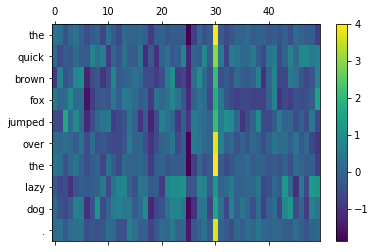

['the', 'pretty', 'flowers', 'shone', 'in', 'the', 'sunlight.']


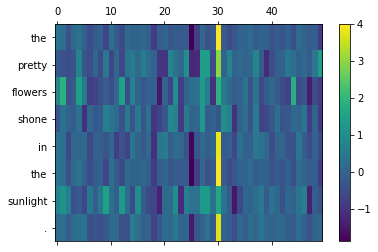

In [6]:
def visualize(sentence):
    rows, words = sentence2sequence(sentence)
    mat = np.vstack(rows)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    shown = ax.matshow(mat, aspect="auto")
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    fig.colorbar(shown)
    
    ax.set_yticklabels([""]+words)
    plt.show()
    
visualize("The quick brown fox jumped over the lazy dog.")
visualize("The pretty flowers shone in the sunlight.")

In [7]:
def contextualize(set_file):
    """
    Read in the dataset of questions and build question+answer -> context sets.
    Output is a list of data points, each of which is a 7-element tuple containing:
        The sentences in the context in vectorized form.
        The sentences in the context as a list of string tokens.
        The question in vectorized form.
        The question as a list of string tokens.
        The answer in vectorized form.
        The answer as a list of string tokens.
        A list of numbers for supporting statements, which is currently unused.
    """
    data = []
    context = []
    with open(set_file, "r", encoding="utf8") as train:
        for line in train:
            l, ine = tuple(line.split(" ", 1))
            # Split the line numbers from the sentences they refer to.
            if l is "1":
                # New contexts always start with 1, 
                # so this is a signal to reset the context.
                context = []
            if "\t" in ine: 
                # Tabs are the separator between questions and answers,
                # and are not present in context statements.
                question, answer, support = tuple(ine.split("\t"))
                data.append((tuple(zip(*context))+
                             sentence2sequence(question)+
                             sentence2sequence(answer)+
                             ([int(s) for s in support.split()],)))
                # Multiple questions may refer to the same context, so we don't reset it.
            else:
                # Context sentence.
                context.append(sentence2sequence(ine[:-1]))
        print(train)
    return data
train_data = contextualize(train_set_post_file)
test_data = contextualize(test_set_post_file)

['bill', 'travelled', 'to', 'the', 'office.']
['bill', 'picked', 'up', 'the', 'football', 'there.']
['bill', 'went', 'to', 'the', 'bedroom.']
['bill', 'gave', 'the', 'football', 'to', 'fred.']
['what', 'did', 'bill', 'give', 'to', 'fred?', '']
['football']
['fred', 'handed', 'the', 'football', 'to', 'bill.']
['jeff', 'went', 'back', 'to', 'the', 'office.']
['who', 'received', 'the', 'football?', '']
['bill']
['bill', 'travelled', 'to', 'the', 'office.']
['bill', 'got', 'the', 'milk', 'there.']
['who', 'received', 'the', 'football?', '']
['bill']
['fred', 'travelled', 'to', 'the', 'garden.']
['fred', 'went', 'to', 'the', 'hallway.']
['bill', 'journeyed', 'to', 'the', 'bedroom.']
['jeff', 'moved', 'to', 'the', 'hallway.']
['jeff', 'journeyed', 'to', 'the', 'bathroom.']
['bill', 'journeyed', 'to', 'the', 'office.']
['fred', 'travelled', 'to', 'the', 'bathroom.']
['mary', 'journeyed', 'to', 'the', 'kitchen.']
['jeff', 'took', 'the', 'apple', 'there.']
['jeff', 'gave', 'the', 'apple', 'to',

In [8]:
final_train_data = []
def finalize(data):
    """
    Prepares data generated by contextualize() for use in the network.
    """
    final_data = []
    for cqas in data:
        contextvs, contextws, qvs, qws, avs, aws, spt = cqas

        lengths = itertools.accumulate(len(cvec) for cvec in contextvs)
        context_vec = np.concatenate(contextvs)
        context_words = sum(contextws,[])
        
        # Location markers for the beginnings of new sentences.
        sentence_ends = np.array(list(lengths)) 
        final_data.append((context_vec, sentence_ends, qvs, spt, context_words, cqas, avs, aws))
    return np.array(final_data)
final_train_data = finalize(train_data)   
final_test_data = finalize(test_data)     

In [9]:
tf.reset_default_graph()

In [10]:
# Hyperparameters

# The number of dimensions used to store data passed between recurrent layers in the network.
recurrent_cell_size = 128

# The number of dimensions in our word vectorizations.
D = 50 

# How quickly the network learns. Too high, and we may run into numeric instability 
# or other issues.
learning_rate = 0.005

# Dropout probabilities. For a description of dropout and what these probabilities are, 
# see Entailment with TensorFlow.
input_p, output_p = 0.5, 0.5

# How many questions we train on at a time.
batch_size = 128

# Number of passes in episodic memory. We'll get to this later.
passes = 4

# Feed Forward layer sizes: the number of dimensions used to store data passed from feed-forward layers.
ff_hidden_size = 256

weight_decay = 0.00000001
# The strength of our regularization. Increase to encourage sparsity in episodic memory, 
# but makes training slower. Don't make this larger than leraning_rate.

training_iterations_count = 400000
# How many questions the network trains on each time it is trained. 
# Some questions are counted multiple times.

display_step = 100
# How many iterations of training occur before each validation check.

In [11]:
# Input Module

# Context: A [batch_size, maximum_context_length, word_vectorization_dimensions] tensor 
# that contains all the context information.
context = tf.placeholder(tf.float32, [None, None, D], "context")  
context_placeholder = context # I use context as a variable name later on

# input_sentence_endings: A [batch_size, maximum_sentence_count, 2] tensor that 
# contains the locations of the ends of sentences. 
input_sentence_endings = tf.placeholder(tf.int32, [None, None, 2], "sentence")

# recurrent_cell_size: the number of hidden units in recurrent layers.
input_gru = tf.contrib.rnn.GRUCell(recurrent_cell_size)

# input_p: The probability of maintaining a specific hidden input unit.
# Likewise, output_p is the probability of maintaining a specific hidden output unit.
gru_drop = tf.contrib.rnn.DropoutWrapper(input_gru, input_p, output_p)

# dynamic_rnn also returns the final internal state. We don't need that, and can
# ignore the corresponding output (_). 
input_module_outputs, _ = tf.nn.dynamic_rnn(gru_drop, context, dtype=tf.float32, scope = "input_module")

# cs: the facts gathered from the context.
cs = tf.gather_nd(input_module_outputs, input_sentence_endings)
# to use every word as a fact, useful for tasks with one-sentence contexts
s = input_module_outputs 

In [12]:
# Question Module

# query: A [batch_size, maximum_question_length, word_vectorization_dimensions] tensor 
#  that contains all of the questions.

query = tf.placeholder(tf.float32, [None, None, D], "query")

# input_query_lengths: A [batch_size, 2] tensor that contains question length information. 
# input_query_lengths[:,1] has the actual lengths; input_query_lengths[:,0] is a simple range() 
# so that it plays nice with gather_nd.
input_query_lengths = tf.placeholder(tf.int32, [None, 2], "query_lengths")

question_module_outputs, _ = tf.nn.dynamic_rnn(gru_drop, query, dtype=tf.float32, 
                                               scope = tf.VariableScope(True, "input_module"))

# q: the question states. A [batch_size, recurrent_cell_size] tensor.
q = tf.gather_nd(question_module_outputs, input_query_lengths)

In [13]:
# Episodic Memory

# make sure the current memory (i.e. the question vector) is broadcasted along the facts dimension
size = tf.stack([tf.constant(1),tf.shape(cs)[1], tf.constant(1)])
re_q = tf.tile(tf.reshape(q,[-1,1,recurrent_cell_size]),size)


# Final output for attention, needs to be 1 in order to create a mask
output_size = 1 

# Weights and biases
attend_init = tf.random_normal_initializer(stddev=0.1)
w_1 = tf.get_variable("attend_w1", [1,recurrent_cell_size*7, recurrent_cell_size], 
                      tf.float32, initializer = attend_init)
w_2 = tf.get_variable("attend_w2", [1,recurrent_cell_size, output_size], 
                      tf.float32, initializer = attend_init)

b_1 = tf.get_variable("attend_b1", [1, recurrent_cell_size], 
                      tf.float32, initializer = attend_init)
b_2 = tf.get_variable("attend_b2", [1, output_size], 
                      tf.float32, initializer = attend_init)

# Regulate all the weights and biases
tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, tf.nn.l2_loss(w_1))
tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, tf.nn.l2_loss(b_1))
tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, tf.nn.l2_loss(w_2))
tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, tf.nn.l2_loss(b_2))

def attention(c, mem, existing_facts):
    """
    Custom attention mechanism.
    c: A [batch_size, maximum_sentence_count, recurrent_cell_size] tensor 
        that contains all the facts from the contexts.
    mem: A [batch_size, maximum_sentence_count, recurrent_cell_size] tensor that 
        contains the current memory. It should be the same memory for all facts for accurate results.
    existing_facts: A [batch_size, maximum_sentence_count, 1] tensor that 
        acts as a binary mask for which facts exist and which do not.
    
    """
    with tf.variable_scope("attending") as scope:
        # attending: The metrics by which we decide what to attend to.
        attending = tf.concat([c, mem, re_q, c * re_q,  c * mem, (c-re_q)**2, (c-mem)**2], 2)
        
        # m1: First layer of multiplied weights for the feed-forward network. 
        #     We tile the weights in order to manually broadcast, since tf.matmul does not
        #     automatically broadcast batch matrix multiplication as of TensorFlow 1.2.
        m1 = tf.matmul(attending * existing_facts, 
                       tf.tile(w_1, tf.stack([tf.shape(attending)[0],1,1]))) * existing_facts
        # bias_1: A masked version of the first feed-forward layer's bias
        #     over only existing facts.

        bias_1 = b_1 * existing_facts
        
        # tnhan: First nonlinearity. In the original paper, this is a tanh nonlinearity; 
        #        choosing relu was a design choice intended to avoid issues with 
        #        low gradient magnitude when the tanh returned values close to 1 or -1. 
        tnhan = tf.nn.relu(m1 + bias_1)
        
        # m2: Second layer of multiplied weights for the feed-forward network. 
        #     Still tiling weights for the same reason described in m1's comments.
        m2 = tf.matmul(tnhan, tf.tile(w_2, tf.stack([tf.shape(attending)[0],1,1])))
        
        # bias_2: A masked version of the second feed-forward layer's bias.
        bias_2 = b_2 * existing_facts
        
        # norm_m2: A normalized version of the second layer of weights, which is used 
        #     to help make sure the softmax nonlinearity doesn't saturate.
        norm_m2 = tf.nn.l2_normalize(m2 + bias_2, -1)
        
        # softmaxable: A hack in order to use sparse_softmax on an otherwise dense tensor. 
        #     We make norm_m2 a sparse tensor, then make it dense again after the operation.
        softmax_idx = tf.where(tf.not_equal(norm_m2, 0))[:,:-1]
        softmax_gather = tf.gather_nd(norm_m2[...,0], softmax_idx)
        softmax_shape = tf.shape(norm_m2, out_type=tf.int64)[:-1]
        softmaxable = tf.SparseTensor(softmax_idx, softmax_gather, softmax_shape)
        return tf.expand_dims(tf.sparse_tensor_to_dense(tf.sparse_softmax(softmaxable)),-1)

# facts_0s: a [batch_size, max_facts_length, 1] tensor 
#     whose values are 1 if the corresponding fact exists and 0 if not.
facts_0s = tf.cast(tf.count_nonzero(input_sentence_endings[:,:,-1:],-1,keep_dims=True),tf.float32)


with tf.variable_scope("Episodes") as scope:
    attention_gru = tf.contrib.rnn.GRUCell(recurrent_cell_size)
    
    # memory: A list of all tensors that are the (current or past) memory state 
    #   of the attention mechanism.
    memory = [q]
    
    # attends: A list of all tensors that represent what the network attends to.
    attends = []
    for a in range(passes):
        # attention mask
        attend_to = attention(cs, tf.tile(tf.reshape(memory[-1],[-1,1,recurrent_cell_size]),size),
                              facts_0s)
        
        # Inverse attention mask, for what's retained in the state.
        retain = 1-attend_to
        
        # GRU pass over the facts, according to the attention mask.
        while_valid_index = (lambda state, index: index < tf.shape(cs)[1])
        update_state = (lambda state, index: (attend_to[:,index,:] * 
                                                 attention_gru(cs[:,index,:], state)[0] + 
                                                 retain[:,index,:] * state))
        # start loop with most recent memory and at the first index
        memory.append(tuple(tf.while_loop(while_valid_index,
                          (lambda state, index: (update_state(state,index),index+1)),
                           loop_vars = [memory[-1], 0]))[0]) 
        
        attends.append(attend_to)
        
        # Reuse variables so the GRU pass uses the same variables every pass.
        scope.reuse_variables()

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [14]:
# Answer Module

# a0: Final memory state. (Input to answer module)
a0 = tf.concat([memory[-1], q], -1)

# fc_init: Initializer for the final fully connected layer's weights.
fc_init = tf.random_normal_initializer(stddev=0.1) 

with tf.variable_scope("answer"):
    # w_answer: The final fully connected layer's weights.
    w_answer = tf.get_variable("weight", [recurrent_cell_size*2, D], 
                               tf.float32, initializer = fc_init)
    # Regulate the fully connected layer's weights
    tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, 
                     tf.nn.l2_loss(w_answer)) 
    
    # The regressed word. This isn't an actual word yet; 
    #    we still have to find the closest match.
    logit = tf.expand_dims(tf.matmul(a0, w_answer),1)
    
    # Make a mask over which words exist.
    with tf.variable_scope("ending"):
        all_ends = tf.reshape(input_sentence_endings, [-1,2])
        range_ends = tf.range(tf.shape(all_ends)[0])
        ends_indices = tf.stack([all_ends[:,0],range_ends], axis=1)
        ind = tf.reduce_max(tf.scatter_nd(ends_indices, all_ends[:,1],
                                          [tf.shape(q)[0], tf.shape(all_ends)[0]]),
                            axis=-1)
        range_ind = tf.range(tf.shape(ind)[0])
        mask_ends = tf.cast(tf.scatter_nd(tf.stack([ind, range_ind], axis=1), 
                                          tf.ones_like(range_ind), [tf.reduce_max(ind)+1, 
                                                                    tf.shape(ind)[0]]), bool)
        # A bit of a trick. With the locations of the ends of the mask (the last periods in 
        #  each of the contexts) as 1 and the rest as 0, we can scan with exclusive or 
        #  (starting from all 1). For each context in the batch, this will result in 1s 
        #  up until the marker (the location of that last period) and 0s afterwards.
        mask = tf.scan(tf.logical_xor,mask_ends, tf.ones_like(range_ind, dtype=bool))
        
    # We score each possible word inversely with their Euclidean distance to the regressed word.
    #  The highest score (lowest distance) will correspond to the selected word.
    logits = -tf.reduce_sum(tf.square(context*tf.transpose(tf.expand_dims(
                    tf.cast(mask, tf.float32),-1),[1,0,2]) - logit), axis=-1)

In [15]:
# Training

# gold_standard: The real answers.
gold_standard = tf.placeholder(tf.float32, [None, 1, D], "answer")
with tf.variable_scope('accuracy'):
    eq = tf.equal(context, gold_standard)
    corrbool = tf.reduce_all(eq,-1)
    logloc = tf.reduce_max(logits, -1, keep_dims = True)
    # locs: A boolean tensor that indicates where the score 
    #  matches the minimum score. This happens on multiple dimensions, 
    #  so in the off chance there's one or two indexes that match 
    #  we make sure it matches in all indexes.
    locs = tf.equal(logits, logloc)
    
    # correctsbool: A boolean tensor that indicates for which 
    #   words in the context the score always matches the minimum score.
    correctsbool = tf.reduce_any(tf.logical_and(locs, corrbool), -1)
    # corrects: A tensor that is simply correctsbool cast to floats.
    corrects = tf.where(correctsbool, tf.ones_like(correctsbool, dtype=tf.float32), 
                        tf.zeros_like(correctsbool,dtype=tf.float32))
    
    # corr: corrects, but for the right answer instead of our selected answer.
    corr = tf.where(corrbool, tf.ones_like(corrbool, dtype=tf.float32), 
                        tf.zeros_like(corrbool,dtype=tf.float32))
with tf.variable_scope("loss"):
    # Use sigmoid cross entropy as the base loss, 
    #  with our distances as the relative probabilities. There are
    #  multiple correct labels, for each location of the answer word within the context.
    loss = tf.nn.sigmoid_cross_entropy_with_logits(logits = tf.nn.l2_normalize(logits,-1),
                                                   labels = corr)
    
    # Add regularization losses, weighted by weight_decay.
    total_loss = tf.reduce_mean(loss) + weight_decay * tf.add_n(
        tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))

# TensorFlow's default implementation of the Adam optimizer works. We can adjust more than 
#  just the learning rate, but it's not necessary to find a very good optimum.
optimizer = tf.train.AdamOptimizer(learning_rate)

# Once we have an optimizer, we ask it to minimize the loss 
#   in order to work towards the proper training.
opt_op = optimizer.minimize(total_loss)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [16]:
def prep_batch(batch_data, more_data = False):
    """
        Prepare all the preproccessing that needs to be done on a batch-by-batch basis.
    """
    context_vec, sentence_ends, questionvs, spt, context_words, cqas, answervs, _ = zip(*batch_data)
    ends = list(sentence_ends)
    maxend = max(map(len, ends))
    aends = np.zeros((len(ends), maxend))
    for index, i in enumerate(ends):
        for indexj, x in enumerate(i):
            aends[index, indexj] = x-1
    new_ends = np.zeros(aends.shape+(2,))

    for index, x in np.ndenumerate(aends):
        new_ends[index+(0,)] = index[0]
        new_ends[index+(1,)] = x

    contexts = list(context_vec)
    max_context_length = max([len(x) for x in contexts])
    contextsize = list(np.array(contexts[0]).shape)
    contextsize[0] = max_context_length
    final_contexts = np.zeros([len(contexts)]+contextsize)

    contexts = [np.array(x) for x in contexts]
    for i, context in enumerate(contexts):
        final_contexts[i,0:len(context),:] = context
    max_query_length = max(len(x) for x in questionvs)
    querysize = list(np.array(questionvs[0]).shape)
    querysize[:1] = [len(questionvs),max_query_length]
    queries = np.zeros(querysize)
    querylengths = np.array(list(zip(range(len(questionvs)),[len(q)-1 for q in questionvs])))
    questions = [np.array(q) for q in questionvs]
    for i, question in enumerate(questions):
        queries[i,0:len(question),:] = question
    data = {context_placeholder: final_contexts, input_sentence_endings: new_ends, 
                            query:queries, input_query_lengths:querylengths, gold_standard: answervs}
    return (data, context_words, cqas) if more_data else data

In [17]:
batch = np.random.randint(final_test_data.shape[0], size=batch_size*10)
batch_data = final_test_data[batch]

validation_set, val_context_words, val_cqas = prep_batch(batch_data, True)

In [18]:
sess1= tf.Session() # Begin session
    
print ('Loading pre-trained weights for the model...')
saver = tf.train.Saver()
print (1)
saver.restore(sess1, 'ckpt/model.ckpt')
print(2)
sess1.run(tf.global_variables())
print ('\nRESTORATION COMPLETE\n')

ancr = sess1.run([corrbool,locs, total_loss, logits, facts_0s, w_1]+attends+
            [query, cs, question_module_outputs],feed_dict=validation_set)
a = ancr[0]
n = ancr[1]
cr = ancr[2]

attenders = np.array(ancr[6:-3]) 
faq = np.sum(ancr[4], axis=(-1,-2)) # Number of facts in each context

limit = 10

# Locations of responses within contexts
indices = np.argmax(n,axis=1)

# Locations of actual answers within contexts 
indicesc = np.argmax(a,axis=1)

Loading pre-trained weights for the model...
1
INFO:tensorflow:Restoring parameters from ckpt/model.ckpt
2

RESTORATION COMPLETE



In [19]:
validation_set

{<tf.Tensor 'answer_1:0' shape=(?, 1, 50) dtype=float32>: (array([[-0.91558 , -0.12075 ,  0.63843 ,  1.472   ,  0.11632 ,  0.33755 ,
          -2.0499  ,  0.21964 ,  0.097769, -0.64489 , -0.61546 ,  0.8568  ,
          -1.7014  , -0.052124,  0.38784 , -1.0433  ,  0.37534 , -0.38657 ,
          -0.25714 , -0.5637  , -0.79887 ,  0.25749 ,  0.1576  ,  0.070925,
           0.7768  , -0.46193 ,  0.4325  , -0.73809 , -0.050493, -0.73209 ,
           1.5184  , -0.56823 ,  0.45444 ,  0.25185 , -0.38543 , -0.23169 ,
          -0.043573,  0.33183 ,  0.87163 ,  0.35468 , -0.097007,  0.40616 ,
          -1.214   ,  0.28709 ,  0.033896,  0.06457 ,  0.10535 , -0.47967 ,
          -1.0724  ,  1.5551  ]]),
  array([[-0.32717 , -0.1474  , -0.082987,  0.20484 ,  0.43271 ,  0.4457  ,
          -1.454   , -0.24652 ,  0.16361 , -0.49096 , -0.41893 ,  0.25944 ,
          -1.1735  , -0.19189 ,  0.32823 , -0.24323 ,  0.76121 , -0.031855,
          -0.34026 , -0.29404 , -0.16006 ,  0.70103 ,  0.79533 , -0.6280

In [20]:
for i,e,cw, cqa in list(zip(indices, indicesc, val_context_words, val_cqas))[limit:limit*2]:
    ccc = " ".join(cw)
    print("TEXT: ",ccc)
    print ("QUESTION: ", " ".join(cqa[3]))
    print ("RESPONSE: ", cw[i], ["Correct", "Incorrect"][i!=e])
    print("EXPECTED: ", cw[e])
    print()

TEXT:  jeff moved to the hallway . jeff travelled to the kitchen . bill moved to the office . bill journeyed to the kitchen . fred travelled to the office . bill travelled to the hallway . mary journeyed to the garden . bill moved to the bathroom . mary moved to the bedroom . mary journeyed to the garden . jeff moved to the garden . fred moved to the kitchen . jeff took the apple there . mary got the football there . jeff handed the apple to mary . mary passed the apple to jeff .
QUESTION:  who gave the apple ?
RESPONSE:  mary Correct
EXPECTED:  mary

TEXT:  mary moved to the kitchen . fred went to the bedroom . mary went back to the hallway . bill got the football there . mary went to the kitchen . fred journeyed to the kitchen . mary moved to the bedroom . jeff travelled to the kitchen . mary moved to the hallway . fred moved to the bedroom . jeff took the milk there . mary went to the bathroom . bill gave the football to mary . mary gave the football to bill . bill travelled to the 

In [21]:
print(np.mean(sess1.run([corrects], feed_dict= prep_batch(final_test_data))[0]))

0.663


In [21]:
sess1.run([corrects], feed_dict= prep_batch(final_test_data))[0]

array([ 1.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,
        1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,
        1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,
        1.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,
        1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,
        1.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,
        1.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,
        0.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,
        1.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
        1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,
        0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  1